In [1]:
!pip install stanza
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=e59f5aa2ee5f44d6f392a671b4a0483e0a13e71d80c55bd2c543d84fa58747f4
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [19]:
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

Saving utils.py to utils (4).py


In [15]:
#import utils
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import save, load
import torch.nn as nn

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset
from torch_geometric.utils import scatter
from torch_geometric.data import download_url

from torch_geometric.nn import GCNConv, GATv2Conv, global_mean_pool
import torch.nn.functional as F
from torch.nn import Linear, Dropout

from functools import partial
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import PolynomialLR
from torch_geometric.nn.pool import global_max_pool
from torch.optim.lr_scheduler import OneCycleLR

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
tweet_list_train = []
sentiment_list_train = []
tweet_list_test = []
sentiment_list_test = []
cv19_graph_data_train = utils.Dataset_from_sentences("train", "/content/processed_train/",
                                                     "/content/drive/MyDrive/GraphDataset/train/",
                                                     tweet_list_train, sentiment_list_train)
cv19_graph_data_test = utils.Dataset_from_sentences("test", "/content/processed_test/",
                                                    "/content/drive/MyDrive/GraphDataset/test/",
                                                    tweet_list_test, sentiment_list_test)
strat_train = load("/content/drive/MyDrive/StratifiedSplit/strat_train.pt")
strat_val = load("/content/drive/MyDrive/StratifiedSplit/strat_val.pt")
print("Loaded training dataset:")
print(cv19_graph_data_train)
print("Loaded test dataset:")
print(cv19_graph_data_test)
print("Loaded training and validation sets as result of stratified k-fold:")
print(strat_train)
print(strat_val)

['/content/processed_train//train.pt']
['/content/processed_test//test.pt']
Loaded training dataset:
Dataset_from_sentences(25948)
Loaded test dataset:
Dataset_from_sentences(6487)
Loaded training and validation sets as result of stratified k-fold:
Dataset_from_sentences(22704)
Dataset_from_sentences(3244)


In [36]:
# GCN definition
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, n_filters, dim_out):
    super().__init__()

    self.first_linear = Linear(dim_in, dim_in)

    self.gcn_list_1 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])
    self.gcn_list_2 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])
    self.gcn_list_3 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])

    #self.gcn_1 = GCNConv(dim_in, dim_in, add_self_loops = True)
    #self.gcn_2 = GCNConv(dim_in, dim_in, add_self_loops = True)
    #self.gcn_3 = GCNConv(dim_in, dim_in, add_self_loops = True)
    self.l_list = torch.nn.ModuleList([Linear(dim_in, 1)
                                      for i in range(0, n_filters)])
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    if enable_log:
        utils.visualize_hidden_graph(x, edge_index)

    #h = self.first_linear(x)

    h_list = []
    for i, gcn_l in enumerate(self.gcn_list_1):
        h = x + gcn_l(x, edge_index)
        h = h.tanh()
        h = h + self.gcn_list_2[i](h, edge_index)
        h = h.tanh()
        h = h + self.gcn_list_3[i](h, edge_index)
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    #print(h_layers.shape)
    h_layers = self.classifier(h_layers)


    """
    h = self.first_linear(x)
    h = h + self.gcn_1(h, edge_index)
    h = h + self.gcn_2(h, edge_index)
    h = h + self.gcn_3(h, edge_index)
    if enable_log:
        visualize_hidden_graph(x, edge_index)
    h = global_mean_pool(h, batch)
    h = self.classifier(h)
    """

    return h_layers

In [51]:
# actual GAT class
# this must be modified
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, n_filters, dim_out, heads= 8):
    super().__init__()
    # dim_in is the number of node features, dim_h is the dimension
    # of the hidden layer, dim_out is the dimension of the output
    # feature vector
    self.first_linear = Linear(dim_in, dim_in)

    self.gat_list_1 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // 2, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_2 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // 2, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_3 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // 2, heads = heads)
                                         for i in range(0, n_filters)])

    self.l_list = torch.nn.ModuleList([Linear(dim_in, 1)
                                      for i in range(0, n_filters)])
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    if enable_log:
        utils.visualize_hidden_graph(x, edge_index)

    #h = self.first_linear(x)

    h_list = []
    for i, gat_l in enumerate(self.gat_list_1):
        h = x + gat_l(x, edge_index)
        h = h.tanh()
        h = h + self.gat_list_2[i](h, edge_index)
        h = h.tanh()
        h = h + self.gat_list_3[i](h, edge_index)
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    #print(h_layers.shape)
    h_layers = self.classifier(h_layers)

In [23]:
class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses over the course of training.
    Args:
        train_losses: A list of training losses.
        val_losses: A list of validation losses.
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [43]:
def train(model, strat_train, strat_val, partial_scheduler, epochs = 30, batch_size = 30, print_every = 1):
    """Train a GNN model and return the trained model."""
    batch_size = batch_size
    criterion = torch.nn.CrossEntropyLoss(label_smoothing = 0.01)
    optimizer = model.optimizer
    scheduler = partial_scheduler(optimizer)
    print(type(scheduler))
    loader_train =  DataLoader(strat_train.data_list, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(strat_val.data_list, batch_size=batch_size, shuffle=True)
    model.train()
    early_stopper = EarlyStopper(patience=10, min_delta=0.2)

    train_losses = []
    val_losses = []

    best_model = []
    best_acc_val = 0
    epochs_to_return = 0

    #scheduler.step()
    for epoch in range(epochs+1):
      mean_loss_train = 0
      mean_acc_train = 0
      for i, batch in enumerate(loader_train):
        # Training

        out = model(batch.x, batch.edge_index, batch.batch)
        loss_train = criterion(out, batch.y.long())
        mean_loss_train += loss_train.item()

        acc_train = accuracy(out.argmax(dim=1), batch.y)
        mean_acc_train += acc_train
        loss_train.backward()
        with torch.no_grad():
            optimizer.step()
            if type(scheduler) == OneCycleLR:
                scheduler.step()
            optimizer.zero_grad()
      mean_loss_train /= i
      mean_acc_train /= i
      train_losses.append(mean_loss_train)
      if type(scheduler) != OneCycleLR:
          scheduler.step()

      mean_loss_val = 0
      mean_acc_val = 0
      with torch.no_grad():
          for i, batch in enumerate(loader_val):
            out = model(batch.x, batch.edge_index, batch.batch)
            loss_val = criterion(out, batch.y.long())
            mean_loss_val += loss_val.item()
            acc_val = accuracy(out.argmax(dim=1), batch.y)
            mean_acc_val += acc_val
            #visualize_embedding(embed, batch.y, epoch, loss_val)
          mean_loss_val /= i
          mean_acc_val /= i
          val_losses.append(mean_loss_val)
          if mean_acc_val > best_acc_val:
                best_acc_val = mean_acc_val
                best_model = copy.deepcopy(model)
                epochs_to_return = epoch

      if(epoch % print_every == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {mean_loss_train:.3f} | Train Acc: '
              f'{mean_acc_train*100:>6.2f}%')
        print(f'Epoch {epoch:>3} | Val Loss: {mean_loss_val:.3f} | Val Acc: '
              f'{mean_acc_val*100:>6.2f}%')
        print("learning rate: " + str(scheduler.get_last_lr()))
      if early_stopper.early_stop(mean_loss_val):
        print("early stopping was triggered, final loss:" + str(mean_loss_val))
        break
    plot_losses(train_losses, val_losses)
    return best_model, best_acc_val, epochs_to_return

In [25]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def build_scheduler_list(epochs = 30, max_lr = 1e-3):
    schedulers = []
    schedulers += [partial(PolynomialLR,
                         total_iters = epochs, # The number of steps that the scheduler decays the learning rate.
                         power = i) for i in range(1, 3)] # The power of the polynomial.
    schedulers += [partial(StepLR,
                                  step_size=epochs//i, gamma=0.5) for i in range(3, 5)]
    schedulers += [partial(CosineAnnealingLR,
                              T_max = epochs, # Maximum number of iterations.
                              eta_min = min_lr) for min_lr in [1e-6, 1e-7, 1e-8]]# Minimum learning rate

    schedulers += [partial(OneCycleLR,
                       max_lr = max_lr, # Upper learning rate boundaries in the cycle for each parameter group
                       steps_per_epoch = i, # The number of steps per epoch to train for.
                       epochs = epochs, # The number of epochs to train for.
                       anneal_strategy = 'cos') for i in [10, 50, 100]] # Specifies the annealing strategy
    return schedulers

In [45]:
def hyperparameter_tuning(model, strat_train, strat_val, scheduler_list, batch_size = 30, epochs = 30):
    print(f"batch size: {batch_size}")
    best_valid_acc = 0
    best_model = []
    best_hyper_params = []
    best_val_acc = 0
    for partial_scheduler in scheduler_list:
        model_out, mean_acc_val, epoch = train(copy.deepcopy(model), strat_train, strat_val,
                                               partial_scheduler, epochs, batch_size = batch_size, print_every=1)
        if mean_acc_val > best_val_acc:
            best_val_acc = mean_acc_val
            best_model = model_out
            best_hyper_params = [partial_scheduler, epoch]
            print(f"Improved result: acc {best_val_acc:.3f}, scheduler:\n {partial_scheduler}\nepoch: {epoch}")
    return best_hyper_params, best_model

In [27]:
strat_train = strat_train.to(device)
strat_val = strat_val.to(device)

In [37]:
model_gcn = GCN(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes).to(device)
print(model_gcn)

GCN(
  (first_linear): Linear(in_features=50, out_features=50, bias=True)
  (gcn_list_1): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (gcn_list_2): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (gcn_list_3): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=50, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


In [29]:
print(get_lr(model_gcn.optimizer))
scheduler_list = build_scheduler_list()
print(scheduler_list)

0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=1), functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=10, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=7, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=30, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=30, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=30, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=10, epochs=30, anneal_strategy='cos'), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=50, epochs=30, anneal_strategy='cos'), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=

batch size: 128
<class 'torch.optim.lr_scheduler.PolynomialLR'>
Epoch   0 | Train Loss: 1.474 | Train Acc:  33.77%
Epoch   0 | Val Loss: 1.408 | Val Acc:  38.31%
learning rate: [0.0009666666666666667]
Epoch   1 | Train Loss: 1.401 | Train Acc:  38.34%
Epoch   1 | Val Loss: 1.382 | Val Acc:  39.78%
learning rate: [0.0009333333333333334]
Epoch   2 | Train Loss: 1.386 | Train Acc:  39.53%
Epoch   2 | Val Loss: 1.381 | Val Acc:  39.57%
learning rate: [0.0009000000000000001]
Epoch   3 | Train Loss: 1.376 | Train Acc:  40.00%
Epoch   3 | Val Loss: 1.371 | Val Acc:  40.19%
learning rate: [0.0008666666666666668]
Epoch   4 | Train Loss: 1.368 | Train Acc:  40.52%
Epoch   4 | Val Loss: 1.356 | Val Acc:  40.78%
learning rate: [0.0008333333333333335]
Epoch   5 | Train Loss: 1.360 | Train Acc:  40.90%
Epoch   5 | Val Loss: 1.374 | Val Acc:  39.70%
learning rate: [0.0008000000000000001]
Epoch   6 | Train Loss: 1.354 | Train Acc:  41.15%
Epoch   6 | Val Loss: 1.349 | Val Acc:  41.65%
learning rate: [

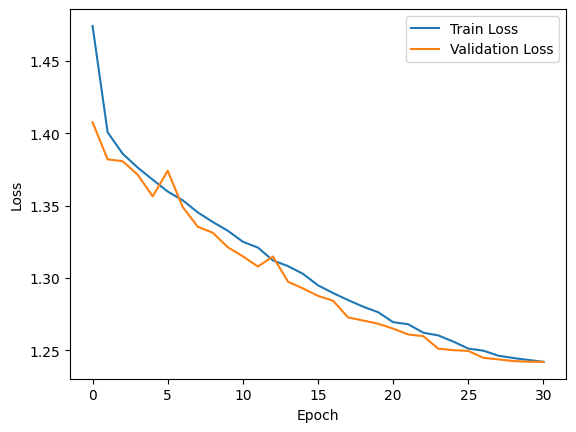

Improved result: acc 0.470, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=1)
epoch: 30
<class 'torch.optim.lr_scheduler.PolynomialLR'>
Epoch   0 | Train Loss: 1.480 | Train Acc:  33.53%
Epoch   0 | Val Loss: 1.422 | Val Acc:  37.10%
learning rate: [0.0009344444444444444]
Epoch   1 | Train Loss: 1.403 | Train Acc:  38.18%
Epoch   1 | Val Loss: 1.388 | Val Acc:  38.92%
learning rate: [0.0008711111111111112]


KeyboardInterrupt: ignored

In [47]:
trained_gcn = hyperparameter_tuning(model_gcn, strat_train, strat_val, scheduler_list, batch_size = 128)

In [49]:
model_gat = GAT(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes).to(device)
print(model_gat)

GAT(
  (gat_list): ModuleList(
    (0-9): 10 x GATv2Conv(50, 25, heads=8)
  )
  (softmax): Softmax(dim=1)
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=200, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=100, power=1), functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=100, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=33, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=25, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=100, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=100, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=100, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=10, epochs=100, anneal_strategy='cos'), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=50, epochs=100, anneal_strategy='cos'), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>,

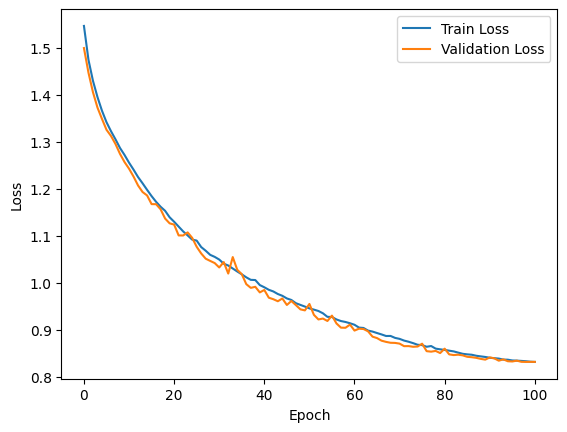

Improved result: acc 0.705, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=100, power=1)
epoch: 99
<class 'torch.optim.lr_scheduler.PolynomialLR'>
Epoch   0 | Train Loss: 1.552 | Train Acc:  31.34%
Epoch   0 | Val Loss: 1.504 | Val Acc:  34.55%
learning rate: [0.0009801]


KeyboardInterrupt: ignored

In [52]:
epochs = 100
print(get_lr(model_gat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_gat, strat_train, strat_val, scheduler_list, batch_size = 128, epochs = epochs)